### Project 1: Profit Estimation

In this project we will be calculated an estimated profit for a company based on its expenses and the location. We will be using a dataset that contains the following columns:
- State
- Administration
- Marketing Spend
- R&D Spend
- Profit

In this we will be using Multiple Linear Regression to predict the profit based on the other columns. The steps would be as following:
- Importing the Libraries
- Studying the Dataset
- Creating Pipelines
- Calculating Model's Accuracy
- Saving the Model
- Creating Interface using Gradio

#### Step 1: Importing the libraries

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import gradio as gr

In [5]:
dataset_url = 'https://raw.githubusercontent.com/digipodium/Datasets/main/regression/50_Startups.csv'
df = pd.read_csv(dataset_url)

#### Step 2: Studying Data

In [6]:
df.head()

,R&D Spend,Administration,Marketing Spend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


There are 4 numerical columns (R & D Spend, Administration, Marketing Spend and Profit) and 1 categorical column (State). In this we would require to rename the columns for better understanding. Profit column will be our target column.

In [7]:
df.rename(columns={'R&D Spend':'Research', 'Marketing Spend':'Marketing'}, inplace=True)
df.head()

,Research,Administration,Marketing,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


In [8]:
print(df.isnull().sum())

Research          0
Administration    0
Marketing         0
State             0
Profit            0
dtype: int64


Now we check the correlation between the columns with the target column.

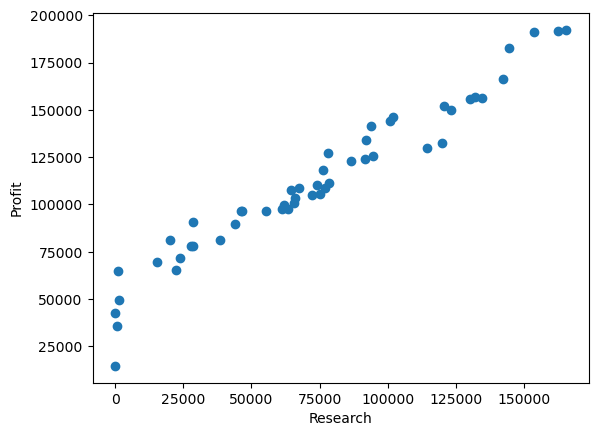

97.29%


In [9]:
plt.plot(df['Research'], df['Profit'], 'o')
plt.xlabel('Research')
plt.ylabel('Profit')
plt.show()
print(f"{df['Research'].corr(df['Profit']) * 100:.2f}%")

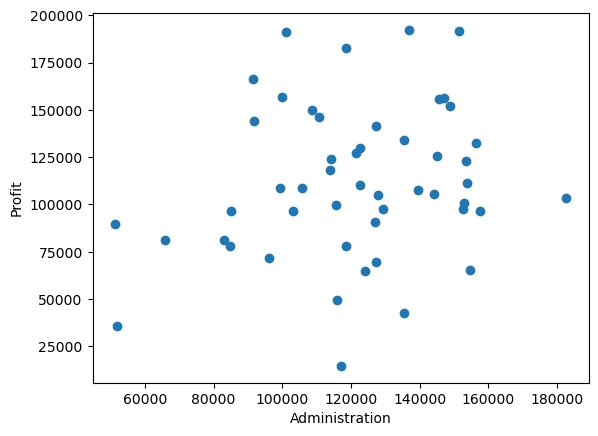

20.07%


In [10]:
plt.plot(df['Administration'], df['Profit'], 'o')
plt.xlabel('Administration')
plt.ylabel('Profit')
plt.show()
print(f"{df['Administration'].corr(df['Profit']) * 100:.2f}%")

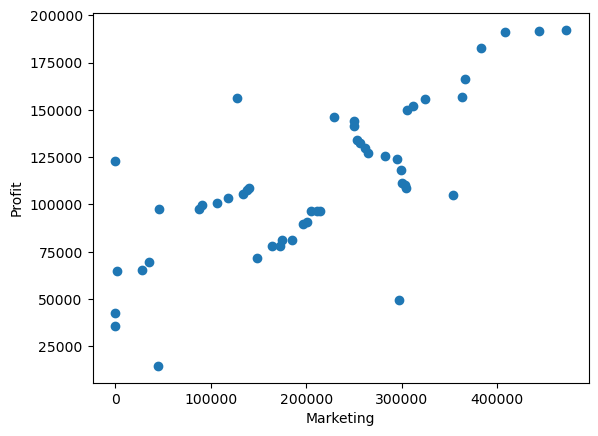

74.78%


In [11]:
plt.plot(df['Marketing'], df['Profit'], 'o')
plt.xlabel('Marketing')
plt.ylabel('Profit')
plt.show()
print(f"{df['Marketing'].corr(df['Profit']) * 100:.2f}%")

Here we can see that there are no null values, so we will not require to impute the data.
We won't need to scale the data. However, we would require to encode the State column.
Since, we know that the Administration column has a very low correlation with the Profit column, we can drop it.

#### Step 3: Creating Pipeline

In [12]:
x = df.drop(['Profit', 'Administration'], axis=1, inplace=False)
y = df['Profit']
numerical_columns = x.select_dtypes(include='number').columns
categorical_columns = x.select_dtypes(include='object').columns
ohe = OneHotEncoder()
ohe.fit(x[categorical_columns])

OneHotEncoder()

In [13]:
numerical_pipeline = Pipeline([
    ('scaler', StandardScaler())
])
categorical_pipeline = Pipeline([
    ('encoder', ohe)
])
preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numerical_columns),
    ('cat', categorical_pipeline, categorical_columns),
])
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Research', 'Marketing'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                                                  Index(['State'], dtype='object'))])),
                ('regressor', LinearRegression())])

#### Step 4: Calculating Model's Accuracy

Split the dataset into training and testing data.

In [14]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

Fit the model on the training data

In [15]:
model.fit(x_train, y_train)
y_train_prediction = model.predict(x_train)
y_test_prediction = model.predict(x_test)

In [16]:
print("Training Results")
print("MSE:", mean_squared_error(y_train, y_train_prediction))
print("MAE:", mean_absolute_error(y_train, y_train_prediction))
print("R2:", r2_score(y_train, y_train_prediction))

Training Results
MSE: 82158239.56230998
MAE: 6328.506840297718
R2: 0.9498261378977877


In [17]:
print("Testing Results")
print("MSE:", mean_squared_error(y_test, y_test_prediction))
print("MAE:", mean_absolute_error(y_test, y_test_prediction))
print("R2:", r2_score(y_test, y_test_prediction))

Testing Results
MSE: 70726699.14473002
MAE: 7109.161997630462
R2: 0.9446968769427515


#### Step 5: Saving the Model and Encoder

In [18]:
joblib.dump(model, 'profit_model.pkl')
joblib.dump(ohe, 'profit_encoder.pkl')

['profit_encoder.pkl']

#### Step 6: Creating Interface using Gradio

In [19]:
def predict_profit(research: int, marketing: int, state: str):
    profit_prediction_model = joblib.load('profit_model.pkl')
    data = pd.DataFrame({
        'Research': [research],
        'Marketing': [marketing],
        'State': [state]
    })
    prediction = profit_prediction_model.predict(data)
    return f"${prediction[0]:.2f}"

In [20]:
predict_profit(100000, 100000, 'Florida')

'$127412.40'

In [21]:
iface = gr.Interface(
    fn=predict_profit,
    inputs=[
        gr.components.Number(label='Research'),
        gr.components.Number(label='Marketing'),
        gr.components.Dropdown(label='State', choices=np.unique(x['State']).tolist())
    ],
    outputs=gr.components.Textbox(label='Profit'),
    title='Profit Estimation',
    description='Enter the details to get the profit'
)

In [22]:
iface.launch()

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.
